### Path setup & Libraries :

In [1]:
project_path = r'C:\Users\omirinioui\PycharmProjects\Projet Quadrature bayésienne'

In [2]:
lib_path = project_path+'\libraries'
port_path = project_path + '\Data\portfolio'
zc_curve_path = project_path+'\Data\ZC Curve'
diff_path = project_path + '\Data\Diffusion'
MC_path =  project_path +'\Results\Full MC'
img_path = project_path +'\Results\Images'


In [3]:
import numpy as np
import pandas as pd

import  numpy as np

import pickle
from time import time
from datetime import timedelta

from PIL import Image
import matplotlib.pyplot as plt

# importing pacakge 
import sys         
sys.path.append(lib_path)        
from main import *
from FinancialData import *

## Data extraction :

In [4]:
ZCR = ZC_Data_extractor(zc_curve_path)    
ZC = zero_coupon_bonds(ZCR, 3) # We chose 3 as degree of the Spline Interpolation 



#load portfolio data
with open(port_path+'\port400irs1fx', 'rb') as f1:
    portfolio = pickle.load(f1)
    
# Set Maturity     
T = portfolio.last_maturity



In [5]:
portfolio.print_as_dict()

{'first_reset_date': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0

In [8]:
irs_specs = np.empty(portfolio.swaps_number,
                     dtype=[('first_reset', '<f4'), ('reset_freq', '<f4'),
                            ('notional', '<f4'), ('swap_rate', '<f4'),
                            ('maturity', '<f4'), ('exercice', '<U10')])  # We set maturity instead of num_resets

irs_specs['first_reset']=portfolio.T0

irs_specs['reset_freq'] = portfolio.freq
irs_specs['notional'] = portfolio.nominal
irs_specs['swap_rate'] = portfolio.strike
irs_specs['exercice'] = portfolio.exercice
irs_specs['maturity'] = portfolio.maturity

In [9]:
pd.DataFrame(irs_specs).to_excel(port_path+ '\port400irs1fx.xlsx')

In [34]:
#load diffusion data
with open(diff_path+'\MC60000p400swap1fx', 'rb') as f1:
    diffusion = pickle.load(f1)
lgm_params = diffusion.get_LGM_params()

In [12]:
#recovery rate & defult probability parameter :
R, lamda = 0.4, 0.005

Le but de ce notebook est d'implémenter une méthode quasi-analytic pour calculer l'exposition en se basant sur l'expression de la prédiction du GPR

## 1. Convergence de l'exposition espèré 

### Convergence de l'intégration numérique :

Le but de cette partie est d'étudier  la convergence de l'intégrale numérique intervenant dans le calcul de l'expopsition converge généralement à partir de $300$ discrétisations dans une somme de Reimman. 

NB: Pour le support on fixe $5 \sigma^{X}_{t}$ pour une date d'exposition $t$ fixé ( Nos tests numérique montre qu'oon converge bien pour ce choix)

In [52]:
def Expected_exposure_benchmark(t, portfolio, ZC, lgm_params , n_std, n_reim) : 
    
    mu_X_t = 0
    std_X_t = diffusion.sig * np.sqrt( (1 - np.exp(-2 * diffusion.lam *t )) / (2 * diffusion.lam) )

    train_range = ( mu_X_t-n_std*std_X_t, mu_X_t+n_std*std_X_t )

    # Pricing 
    X = np.linspace(train_range[0], train_range[1], n_reim)
    mtm = portfolio.Mtm_mono(t,X,ZC,lgm_params)

    Y = np.maximum(mtm, 0)*norm.pdf(X, mu_X_t, std_X_t)

    return ZC.initial_zcb_curve(t) * (np.diff(X)*Y[1:]).sum()

In [72]:
t = 1 # We tested for different values of t 
Nreim_values = np.array([50,100, 200, 300, 500 ,1000, 1500])

EE_convergence = np.zeros((Nreim_values.shape[0]))
for n_reim in Nreim_values :
    i = list(Nreim_values).index(n_reim)
    EE_convergence[i] = Expected_exposure_benchmark(t, portfolio, ZC, lgm_params , n_std, n_reim)


In [73]:
ee_df = pd.DataFrame(EE_convergence, columns= ['Expected Exposure'], index=Nreim_values).astype(int)
ee_df

,Expected Exposure
50,41019
100,41002
200,40997
300,40996
500,40997
1000,40996
1500,40997


In [63]:
ee_df.to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Convergence of the expected exposure based on a numerical integration with respect to  $X_{t}$ at fixed date $t$",  # The caption to appear above the table in the LaTeX document  # A label used for referencing the table within the LaTeX document
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
)

'\\begin{table}[htbp]\n\\caption{Convergence of the expected exposure based on a numerical integration with respect to  $X_{t}$}\n\\begin{tabular}{|l|l|l|l|}\n\\toprule\nExpected Exposure \\\\\n\\midrule\n41019 \\\\\n41002 \\\\\n40997 \\\\\n40996 \\\\\n40997 \\\\\n40996 \\\\\n40997 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

Dans la majorité des test on retient qu'on converge avec 300 discrétisation 

## 2. Convergence de la CVA par intégration numérique du Mark-to Market par rappor à $X_{t}$  :

Dans cette partie on étudie la convergence de la CVA en utlisant une intégration numérique dans le calcul de l'exposition : 

Pour l'intégration numérique dans l'exposition on utlise toujours : $300$ discrétisations de temps et un support de  $5 \sigma^{X}_{t}$

Calulcaltion for 50 is Done ------
Calulcaltion for 100 is Done ------
Calulcaltion for 300 is Done ------
Calulcaltion for 500 is Done ------
Calulcaltion for 700 is Done ------
Total Calculation Time : 0:03:51


,Discretization,CVA,Computation Time
0,50,436,6
1,100,430,13
2,300,431,41
3,500,432,72
4,700,432,96


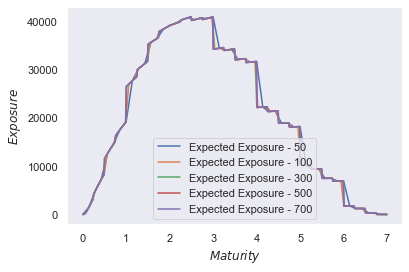

In [31]:
n_std , integ_pts = 5, 300
discretisations = [50,100,300,500,700]

cva_integration =  pd.DataFrame(columns=['Discretization', 'CVA' , 'Computation Time'])

start = time()
for n in discretisations :
    time_grid = np.linspace(0,T,n)
    
    mc_start = time()
    
    EE =np.array([ Expected_exposure_benchmark(t, portfolio, ZC, diffusion.get_LGM_params() , n_std, integ_pts)  if 0<t and t<T else 0 for t in time_grid])
    PD = np.array([ lamda * np.exp(-lamda *t) for t in time_grid])
    Y = (1-R)*EE*PD
    cva = (np.diff(time_grid)*Y[1:]).sum()
    
    cva_integration.loc[len(cva_integration)] = [ round(n) , cva, time() - mc_start]
    
   
    plt.plot(time_grid, EE, label="Expected Exposure - "+str(n))
    plt.legend()
    plt.xlabel(r"$Maturity$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)

    print('Calulcaltion for '+str(n)+' is Done ------')

    
print('Total Calculation Time :' , "{}".format(str( timedelta( seconds=round(time()-start) ) )))
cva_integration.astype(int)

In [32]:
cva_integration.astype(int).to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Convergence of CVA based on a numerical integration of GPR estimator with respect to  $X_{t}$",  # The caption to appear above the table in the LaTeX document  # A label used for referencing the table within the LaTeX document
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
)

'\\begin{table}[htbp]\n\\caption{Convergence of CVA based on a numerical integration of GPR estimator with respect to  $X_{t}$}\n\\begin{tabular}{|l|l|l|l|}\n\\toprule\nDiscretization & CVA & Computation Time \\\\\n\\midrule\n50 & 436 & 10 \\\\\n100 & 430 & 22 \\\\\n300 & 431 & 70 \\\\\n500 & 432 & 119 \\\\\n700 & 432 & 173 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

        on converge pour 500 discrétisation (Graphiquement et numériquement) vers une valeur de 432 euro 